# Importing Required Modules

In [44]:
import numpy as np
import pandas as pd
import pickle
import nltk
import re

import matplotlib.pyplot as plt
import seaborn as sns

from nltk import word_tokenize
from collections import defaultdict
from nltk import FreqDist
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import train_test_split

# Supervised Learning
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# Unsupervised Learning
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
# nltk.download('punkt')

In [3]:
# nltk.download('stopwords')

# Loading The Text Data

In [4]:
info = pd.read_excel('280-285 (1).xlsx')
info

,HADM_ID,TEXT,LABLE
0,100003,Admission Date: [**2150-4-17**] ...,285
1,100009,Admission Date: [**2162-5-16**] ...,285
2,100011,Admission Date: [**2177-8-29**] ...,285
3,100021,Admission Date: [**2109-8-17**] ...,281
4,100030,Admission Date: [**2199-12-3**] Dischar...,285
...,...,...,...
95,100612,Admission Date: [**2191-1-27**] ...,285
96,100622,Admission Date: [**2189-2-26**] ...,285
97,100636,Admission Date: [**2189-1-17**] ...,285
98,100638,Admission Date: [**2158-3-31**] ...,285


# Data Preprocessing I: Basic Preprocessing

In [5]:
info.isna().sum()

HADM_ID    0
TEXT       0
LABLE      0
dtype: int64

In [6]:
info.dtypes

HADM_ID     int64
TEXT       object
LABLE      object
dtype: object

In [7]:
info[info['LABLE'] == '284, 285']

,HADM_ID,TEXT,LABLE
6,100037,Admission Date: [**2183-3-23**] ...,"284, 285"


In [8]:
info[info['LABLE'] == '280, 285']

,HADM_ID,TEXT,LABLE
67,100446,Admission Date: [**2122-3-28**] ...,"280, 285"


In [9]:
info['LABLE'] = info['LABLE'].apply(lambda x: str(x)).apply(lambda x: x.split(', '))
info = info.explode('LABLE')

info = info.reset_index(drop=True)

In [10]:
info.isna().sum()

HADM_ID    0
TEXT       0
LABLE      0
dtype: int64

In [11]:
info.dtypes

HADM_ID     int64
TEXT       object
LABLE      object
dtype: object

In [12]:
info['LABLE'] = info['LABLE'].astype(int)

In [41]:
info['LABLE'].value_counts()

285    75
284    11
280     8
281     6
282     2
Name: LABLE, dtype: int64

In [13]:
info.dtypes

HADM_ID     int64
TEXT       object
LABLE       int32
dtype: object

In [14]:
# Clean data
info

,HADM_ID,TEXT,LABLE
0,100003,Admission Date: [**2150-4-17**] ...,285
1,100009,Admission Date: [**2162-5-16**] ...,285
2,100011,Admission Date: [**2177-8-29**] ...,285
3,100021,Admission Date: [**2109-8-17**] ...,281
4,100030,Admission Date: [**2199-12-3**] Dischar...,285
...,...,...,...
97,100612,Admission Date: [**2191-1-27**] ...,285
98,100622,Admission Date: [**2189-2-26**] ...,285
99,100636,Admission Date: [**2189-1-17**] ...,285
100,100638,Admission Date: [**2158-3-31**] ...,285


# Understanding The Data

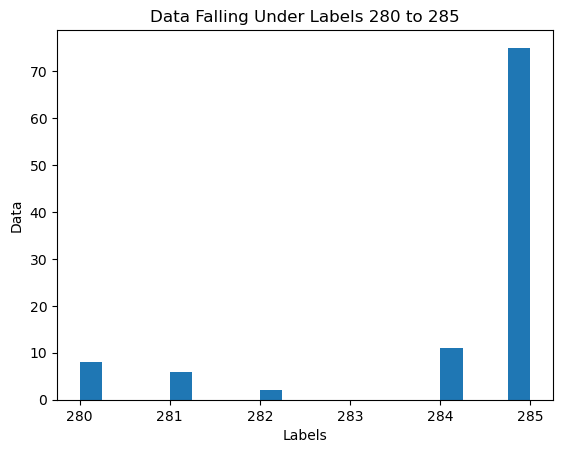

In [15]:
plt.hist(info.LABLE, bins=20)
plt.title("Data Falling Under Labels 280 to 285")
plt.ylabel("Data")
plt.xlabel("Labels")
plt.show()

###### **Observation**
*Maximum data* are labeled with **ICD 11 code "285"**. According to **ICD 11**, "285" or **"XN285"** refers to a rod-shaped bacterial species called **"Shigella Dysenteriae"** that causes **"shigellosis"** in humans. **"Shigellosis"** is a diarrheal illness that are generally treated with **antibiotics** such as **"Ciprofloxacin"** and **"Azithromycin"**. Due to this disease patients suffer from high *fever* and *diarrhea*.

Near about 70% of the patients whoes data are recorded in the dataset are suffering from (or suffered from) shigellosis.

# Data Preprocessing II: Processing Textual Data
___Application of stopwords, lemmatization, tokenization, and main feature extraction___

In [16]:
info['TEXT'].iloc[1]

'Admission Date:  [**2162-5-16**]              Discharge Date:   [**2162-5-21**]\n\nDate of Birth:  [**2101-7-30**]             Sex:   M\n\nService: CARDIOTHORACIC\n\nAllergies:\nNo Known Allergies / Adverse Drug Reactions\n\nAttending:[**First Name3 (LF) 1505**]\nChief Complaint:\nAngina\n\nMajor Surgical or Invasive Procedure:\n[**2162-5-17**]: CABGx4 LIMA-> LAD, RSVG-> Diagonal, Posterior\nDescending Artery, Obtuse marginal\n[**2162-5-19**]: Right Atrial lead placement\n\n\nHistory of Present Illness:\n60yo man with known coronary disease (AMI in [**2143**] and [**Name Prefix (Prefixes) **] [**Last Name (Prefixes) **]\nLCx [**2155**]). Doing well until last week when he developed angina\ninitially with exertion then progressed to rest angina. Each\nepisode was releived with SL NTG, no episode lasting more than 5\nminutes. He presented to cardiologist for treatment. He was\nadmitted to MWMC, a cardiac catheterization revealed 3 vessel\ndisease. He was transferred to [**Hospital1 18**

In [17]:
len(info['TEXT'])

102

In [18]:
# Cleaning Data Cell By Cell
# "cell_value" is the content of the ith cell of the column "TEXT" where i = {0, 1, 2, ..., 101}
def preprocess_text_data(cell_value):
  # Removing the brackets and other special characters
  cell_value = re.sub('\[.*?\]', ' ', cell_value)

  # Remove special characters and digits
  cell_value = re.sub('[^a-zA-Z]', ' ', cell_value)

  # Convert to lowercase
  cell_value = cell_value.lower()

  # Tokenize the text
  tokens = word_tokenize(cell_value)

  # Remove stopwords
  stop_words = set(stopwords.words('english'))
  tokens = [token for token in tokens if token not in stop_words]
  # print(tokens)

  # Join tokens back into a single string
  preprocessed_text_data = ' '.join(tokens)
  return preprocessed_text_data

In [19]:
for i in range(len(info['TEXT'])):
  info['TEXT'].iloc[i] = preprocess_text_data(info['TEXT'].iloc[i])
print(info['TEXT'])

0      admission date discharge date date birth sex s...
1      admission date discharge date date birth sex s...
2      admission date discharge date date birth sex s...
3      admission date discharge date date birth sex s...
4      admission date discharge date date birth sex s...
                             ...                        
97     admission date discharge date date birth sex s...
98     admission date discharge date date birth sex s...
99     admission date discharge date date birth sex s...
100    admission date discharge date date birth sex s...
101    admission date discharge date date birth sex s...
Name: TEXT, Length: 102, dtype: object


In [20]:
info['TEXT'].iloc[1]

'admission date discharge date date birth sex service cardiothoracic allergies known allergies adverse drug reactions attending chief complaint angina major surgical invasive procedure cabgx lima lad rsvg diagonal posterior descending artery obtuse marginal right atrial lead placement history present illness yo man known coronary disease ami lcx well last week developed angina initially exertion progressed rest angina episode releived sl ntg episode lasting minutes presented cardiologist treatment admitted mwmc cardiac catheterization revealed vessel disease transferred coronary bypass grafting cardiac catheterization date place mwmc lad chronic total occlusion proximally distal filling via collaterals rca chronic total occlusion non dominant rca lcx new complex stenosis prox lcx involving bifurcation lcx proper large om old stent lcx widely patent mod lv systolic dysfx anterior apical infero apical ak reduced ef lvedp mmhg valvular dz past medical history cad ami lcx cardiomyopathy ef

In [21]:
def remove_remaining_irrelevant_words(cell_value, more_stopwords):
  tokens2 = word_tokenize(cell_value)
  stop_words2 = set(more_stopwords)
  tokens2 = [token for token in tokens2 if token not in stop_words2]

  preprocessed_text_data2 = ' '.join(tokens2)
  return preprocessed_text_data2

In [22]:
additional_stopwords = ['admission', 'date', 'discharge', 'birth', 'sex', 
                        'service', 'allergies', 'attending', 'chief', 'complaint', 
                        'major', 'procedure', 'history', 'present', 'illness',
                        'known', 'adverse', 'reactions','attending', 'descending',
                        'placement', 'yo', 'man', 'well', 'last', 'week', 'episode',
                        'releived', 'lasting', 'minutes', 'presented', 'admitted',
                        'mwmc', 'date', 'place', 'via', 'new', 'pocket', 'totbili']
for i in range(len(info['TEXT'])):
  info['TEXT'].iloc[i] = remove_remaining_irrelevant_words(info['TEXT'].iloc[i], additional_stopwords)
print(info['TEXT'])

0      medicine patient recorded drugs coffee ground ...
1      cardiothoracic drug angina surgical invasive c...
2      surgery patient recorded drugs helmeted motocy...
3      medicine patient recorded drugs b l ankle frac...
4      hypoxia year old male significant past medical...
                             ...                        
97     cardiothoracic patient recorded drugs pt refer...
98     cardiothoracic monopril lipitor amiodarone adh...
99     cardiothoracic drug chest pain surgical invasi...
100    medicine patient recorded drugs shortness brea...
101    surgery patient recorded drugs p ft fall surgi...
Name: TEXT, Length: 102, dtype: object


In [23]:
info['TEXT'].iloc[1]

'cardiothoracic drug angina surgical invasive cabgx lima lad rsvg diagonal posterior artery obtuse marginal right atrial lead coronary disease ami lcx developed angina initially exertion progressed rest angina sl ntg cardiologist treatment cardiac catheterization revealed vessel disease transferred coronary bypass grafting cardiac catheterization lad chronic total occlusion proximally distal filling collaterals rca chronic total occlusion non dominant rca lcx complex stenosis prox lcx involving bifurcation lcx proper large om old stent lcx widely patent mod lv systolic dysfx anterior apical infero apical ak reduced ef lvedp mmhg valvular dz past medical cad ami lcx cardiomyopathy ef depending study ventricular tachycardia p aicd atrial flutter p ablation hypertension dyslipidemia insulin dependent diabetes mellitus obesity conduction disease lafb peripheral vascular disease p right fem bypas left leg claudication right thigh tumor p radiation excision social race caucasian dental exam 

# Frequency of the occurrence of each tokens (or words) classified by the labels from 280 to 285

In [24]:
def frequently_occurring(row):
    tokens = defaultdict(list)
    for elements in row:
        labels = row[2]
        texts = row[1]
        
        text_tokens = word_tokenize(texts)
        tokens[labels].extend(text_tokens)
        
    for categories, category_tokens in tokens.items():
        print(categories)
        dist = FreqDist(category_tokens)
        print(dist.most_common(20))

In [25]:
for i in range(len(info['TEXT'])):
    frequently_occurring(info.iloc[i])

285
[('mg', 51), ('blood', 51), ('tablet', 51), ('daily', 48), ('one', 42), ('sig', 36), ('pm', 33), ('pt', 30), ('day', 30), ('po', 30), ('take', 27), ('pain', 18), ('naproxen', 18), ('neg', 18), ('normal', 18), ('emesis', 15), ('egd', 15), ('right', 15), ('w', 15), ('cirrhosis', 15)]
285
[('tablet', 102), ('left', 48), ('sig', 48), ('po', 45), ('right', 42), ('one', 42), ('patient', 39), ('mg', 39), ('disp', 39), ('refills', 39), ('p', 30), ('day', 27), ('atrial', 24), ('ventricular', 24), ('daily', 24), ('disease', 21), ('lcx', 21), ('seen', 21), ('call', 21), ('apical', 18)]
285
[('right', 60), ('ct', 57), ('fracture', 39), ('hct', 39), ('blood', 36), ('patient', 33), ('wbc', 33), ('rbc', 33), ('hgb', 33), ('mcv', 33), ('mch', 33), ('mchc', 33), ('rdw', 33), ('plt', 33), ('mg', 30), ('sig', 30), ('ml', 24), ('femur', 21), ('head', 18), ('left', 18)]
281
[('fracture', 72), ('patient', 66), ('ct', 63), ('left', 45), ('tablet', 45), ('de', 42), ('fractures', 39), ('right', 39), ('evid

# Prediction Models: Application of Supervised and Unsupervised Learning

## Data Preparation: 
- __Feature Selection:__ Train-test Split
- __Bag of Words:__ Vectorization

In [26]:
def split_data(info):
    x = info.drop(['LABLE','HADM_ID'], axis = 1)
    # print(x.shape)
    y = info['LABLE']
    # print(y.shape)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = None, shuffle=True)
    
    return np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

In [27]:
def model_performance(title, model_classifier, vectorizer, x_test, y_test):
    x_test_ifidf = vectorizer.transform(x_test.ravel())
    pred = model_classifier.predict(x_test_ifidf)
    
    print(classification_report(y_test, pred))
    print(confusion_matrix(y_test, pred))

In [73]:
def model_performance_TM(model, train_val, test_val, feature_names):
    perplexity = model.perplexity(test_val)
    print("******************************************************************************************************************")
    print(f"Model Perplexity: {perplexity:.2f}")
    
    num_top_words = 10
    feature_names = feature_names
    
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-num_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print("******************************************************************************************************************")
        print(f"Top words associated with Topic {topic_idx}: {' '.join(top_words)}")
    print("******************************************************************************************************************")

## Model 1: Multinomial Naive Bayes (Supervised)

In [28]:
def train_models(info):
    x_train, x_test, y_train, y_test = split_data(info)
    # print(x_train.shape)
    # print(x_test.shape)
    # print(y_train.shape)
    # print(y_test.shape)
    
    vectorize = CountVectorizer(stop_words='english',
                               ngram_range=(1, 3),
                               min_df=0.3, analyzer='word')
    x_train_vectorized = vectorize.fit_transform(x_train.ravel())
    # print(x_train_vectorized)
    
    modNB = MultinomialNB().fit(x_train_vectorized, y_train)
    print("Classification Report For Training Data")
    model_performance("Text Classification Using Naive Bayes Supervised Algorithm\tTrain\t", modNB, vectorize, x_train, y_train)
    print("Classification Report For Test Data")
    model_performance("Text Classification Using Naive Bayes Supervised Algorithm\tTest\t", modNB, vectorize, x_test, y_test)
    
    model_file_name = "Text_Classifier_Multinomial_Naive_Bayes.pkl"
    pickle.dump(modNB, open(model_file_name, 'wb'))
    
    vectorizer_file_name = "Vectorizer_MNB.pkl"
    pickle.dump(vectorize, open(vectorizer_file_name, 'wb'))

In [29]:
train_models(info)

Classification Report For Training Data
              precision    recall  f1-score   support

         280       0.67      1.00      0.80         6
         281       0.62      1.00      0.77         5
         282       1.00      1.00      1.00         2
         284       0.44      1.00      0.61         7
         285       1.00      0.73      0.85        56

    accuracy                           0.80        76
   macro avg       0.75      0.95      0.80        76
weighted avg       0.90      0.80      0.82        76

[[ 6  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  2  0  0]
 [ 0  0  0  7  0]
 [ 3  3  0  9 41]]
Classification Report For Test Data
              precision    recall  f1-score   support

         280       0.00      0.00      0.00         2
         281       0.00      0.00      0.00         1
         284       0.00      0.00      0.00         4
         285       0.64      0.47      0.55        19

    accuracy                           0.35        26
   macro avg      

In [30]:
def classify_random_test_data(text, model_name, vector_name):
    classifier_name = model_name
    load_classifier = pickle.load(open(classifier_name, 'rb'))
    
    vectorizer_name = vector_name
    load_vectorizer = pickle.load(open(vectorizer_name, 'rb'))
    
    predicted_value = load_classifier.predict(load_vectorizer.transform([text]))
    
    print(predicted_value[0])

In [31]:
"""
                            1. Open the "280-285 (1).xlsx" file in excel
                            2. Copy any cell value from the "TEXT" column
                            3. Assign the entire text data to the "test_text" variable defined below
"""

test_text = """Admission Date:  [**2176-4-22**]              Discharge Date:   [**2176-5-7**]

Date of Birth:  [**2103-8-5**]             Sex:   F

Service: MEDICINE

Allergies:
Penicillins / Bactrim / Aspirin / Compazine / Nifedipine /
Morphine

Attending:[**First Name3 (LF) 783**]
Chief Complaint:
Hemoptysis.

Major Surgical or Invasive Procedure:
1. Endotracheal intubation (x2)
2. Thoracentesis (x2 with pigtail catheter placement x1)
3. Bronchoscopy


History of Present Illness:
72 YOF Hx of pulmonary hypertension who presents with massive
hemoptysis. Per the family had a recent hospitalization for
heart failure. Has been having small amounts of hemoptysis for
weeks (less than a teaspoon). This evening patient became
acutely short of breath and hit her lifeline. She is on
anticoagulation and has had several falls recently. She fell ~ 2
days ago and has had abdominal pain ever since (mostly LLQ). No
N/V.
In the ED, patient was coughing up blood and clots. INR reversed
with FFP and vit K. Intubated. Gastric tube placed also with
blood return. Was tachycardic and hypertensive, never
hemodynamically unstable. Given levofloxacin for empiric
pneumonia coverage.


Past Medical History:
1. Pulmonary hypertension
2. Severe [4+] tricuspid regurgitation
3. Atrial fibrillation on coumadin
4. TIA ([**2166-1-28**])
5. Hypertension
6. SLE with joint involvement, malar rash
7. Chronic Pain syndrome
8. Fibromyalgia
9. OSA on CPAP
10. GERD
11. IBS
12. Gout
13. Anemia: Iron deficency anemia with negative upper and lower
endoscopy
14. Falls (history of)


Social History:
Lives on her own with daughter upstairs and son downstairs. H/o
social smoking and drinking.


Family History:
Hypertension, CAD, Cancer.

Physical Exam:
Vitals: T:99.5 BP:126/72 P:88 R:17 SaO2: 100%
General: Awake, alert, intubated.
HEENT: NC/AT, PERRL, EOMI without nystagmus, no scleral icterus
noted, dried blood on lips.
Neck: supple, no JVD or carotid bruits appreciated
Pulmonary: Lungs coarse b/l
Cardiac:irregular, distant, tachy, nl. S1S2
Abdomen: soft, diffusely tender, ND, normoactive bowel sounds,
no masses or organomegaly noted.
Extremities: No edema, 2+ radial, DP and PT pulses b/l.
Skin: no rashes or lesions noted.
Neurologic:
awake, alert. moving all 4 extremeties


Pertinent Results:
Admit Labs:  [**2176-4-22**]
WBC-22.7*# RBC-5.16# HGB-13.0# HCT-40.2# MCV-78* MCH-25.3*
MCHC-32.4 RDW-20.5*

PT-150* PTT-113.8* INR(PT)->22.8*

GLUCOSE-159* LACTATE-3.8* NA+-138 K+-3.2* CL--84* TCO2-37*
UREA N-47* CREAT-1.5*

Discharge Labs:  [**2176-5-5**]
WBC-7.9 RBC-3.81* Hgb-9.7* Hct-31.6* MCV-83 MCH-25.5* MCHC-30.7*
RDW-24.0* Plt Ct-503*

Glucose-97 UreaN-11 Creat-1.0 Na-138 K-3.3 Cl-97 HCO3-30
AnGap-14

EKG:
irregular. rate 130 bpm. nl axis. narrow qrs. LVH. ST depression
in II, aVF, V4-6

CXR ([**2176-4-22**]):
There has been interval placement of endotracheal tube, which
lies 4 cm above the carina. Nasogastric tube is seen extending
below the diaphragm and out of view. Patient is slightly rotated
on current radiograph, limiting evaluation. Marked global
cardiomegaly is probably unchanged. Mediastinal widening is
difficult to assess given the degree of rotation. No focal
consolidations are seen, and there is no pleural effusion or
pneumothorax.

ABD US ([**2176-4-22**]):
Cholelithiasis without son[**Name (NI) 493**] evidence of cholecystitis.

ECHO ([**2176-4-23**]):The left atrium is mildly dilated. The right
atrium is moderately dilated. Left ventricular wall thickness,
cavity size, and systolic function are normal (LVEF>55%). Due to
suboptimal technical quality, a focal wall motion abnormality
cannot be fully excluded. The right ventricular cavity is
dilated. Right ventricular systolic function is normal.
[Intrinsic right ventricular systolic function is likely more
depressed given the severity of tricuspid regurgitation.] The
aortic valve leaflets appear structurally normal with good
leaflet excursion. No aortic regurgitation is seen. The mitral
valve leaflets are structurally normal. No mitral regurgitation
is seen. There is moderate pulmonary artery systolic
hypertension. There is no pericardial effusion.

Compared with the prior study (images reviewed) of [**2176-3-8**],
global
biventricular systolic function is similar. The severity of
tricuspid regurgitation and the estimated pulmonary artery
systolic pressure are now lower (may be related to technical
quality rather than a true decline).

XRAY SHOULDER and HIP and WRIST ([**2176-4-23**]):
Mild left acromioclavicular joint arthrosis. No fracture. No hip
fracture.
Wrist - Diffuse demineralization.
Mild degenerative change about the articular surfaces of the
scapholunate interval. The intercarpal spaces are normal on this
non-stress view.

CT HEAD ([**2176-4-23**]):
No intracranial hemorrhage. Mild chronic microvascular ischemic

changes.

CT CHEST ([**2176-4-23**]):
1. New large left pleural effusion, predominantly loculated.
2. Bronchomalacia bronchus intermedius. Possible air
extravasation.
3. Marked cardiomegaly, especially right atrial enlargement due
to tricuspid insufficiency. Pulmonary hypertension.
4. Bibasilar atelectasis. Right lower lobe pneumonia cannot be
excluded.
5. Mediastinal lymphadenopathy, slightly increased, most likely
reactive, but other causes such as neoplasm can not be excluded.


CT CHEST/ABD/PELVIS ([**2176-4-28**]):
1. Decrease in left pleural effusion, status post left pleural
catheter. Loculated effusion persists in the anterior pleural
space with new focal areas of air within the effusion that could
be secondary to recent intervention.
2. Increasing atelectasis with consolidation of the right lower
lung with opacification of the right lower lobe bronchus with
endobronchial secretions.
3. Persistent cardio megaly and small pericardial effusion.
4. Right renal cysts


Brief Hospital Course:
1. Hemoptysis/anemia:
In setting of supratherapeutic INR (22) and pulmonary
hypertension. Bleeding stopped once INR reversed. Bronchoscopy
initially showed large clot across the carina but no active
bleeding. Repeat bronchoscopy showed slight ooze from LLL. Again
no active bleeding but a large clot. IP subsequently came and
removed the clot.  After INR reversal and clot removal, patient
no longer had hemoptysis and hematocrit remained stable.

2. Respiratory failure (pneumonia and pleural effusions):
Patient intubated in ED for hemoptysis. Extubated the following
morning but had increasing respiratory difficulty through out
the day and was re-intubated in early evening. In addition to
hemoptysis and heart failure, patient developed aspiration
pneumonia. Sputum showed GPC on gram stain but cultures negative
(taken while on levofloxacin). Vancomycin was added. CT scan of
the chest showed left loculated pleural effusion that was tapped
on [**4-25**] by IR showed 4+ PMNs but no organism.  IP further
drained the L posterior loculated fluid (~900cc) and a pigtail
catheter was placed on [**2176-4-26**].  The pigtail catheter can be
removed when drainage stops.  Pt developed fever on [**4-27**] despite
being on vanc/levofloxacin and aztreonam was added after
panculture was obtained.  Repeat CT chest subsequently showed
improved L posterior pleural effusion, unchanged L loculated
pleural effusion (too small to tap) and increased opacities in
the RLL.  Because all her sputum, pleural fluid cultures were
negative, vancomycin and aztreonam were discontinued on [**4-29**] and
[**4-30**], respectively.  A 10 day course of Levaquin was completed.
Patient was extubated successfully on [**4-29**], and at the time of
transfer was satting well on room air.

3. Coagulopathy:
On coumadin for a fib. Her coumadin dose was increased a week
prior to admission.  Unclear why INR so dramatically elevated.
Reversed with FFP and PO vitK. and had no longer hemoptysis.

4. Congestive heart failure, diastolic:
Initially BB/diuretics were held due to hypotension.  They were
reintroduced once hemodynamically stable.

5. Atrial fibrillation:
Initially held BB given hypotension.  Metoprolol was readded to
control her rate (and titrated up).  Her elevated INR was
reversed as above.  Given her recurrent falls per family and
hemoptysis, patient was not felt to be a good candidate for
anticoagulation; given her aspirin allergy, Plavix was started.

6. Renal failure:
Likely in the setting of blood loss and hypertension.  SCr 1.0
at the time of discharge after peaking to 1.5 on admission.

7. Mental status change:
After arriving to the floor, the patient would become mildy
agitated at night and would also become disoriented.  This was
felt to be secondary to narcotics provided earlier in her stay.
Her pain regimen was changed with the hope to minimize narcotics
use.  Tylenol RTC was given and a Lidocaine patch was applied to
her left flank.  Low doses of oxycodone IR and Ultram were used.
 Geriatrics was consulted and recommended low dose of [**Hospital1 **] Haldol
and re-institution of Klonopin, given that the patient presented
on chronic benzoes.  This worked well and the patient improved
greatly with no issues over the final 3-4 days of her stay.

8. Pain:
The patient presented with a history of chronic pain.  Based on
prior PCP notes, multiple regimens have been tried with no only
moderate success.  At the time of discharge, her pain regimen
was as outlined in #7.  Consideration could be given to
eliminating oxycodone in favor of the Ultram if the latter is
working well.

9. Hypertension:
Presented on Nifedipine SR 60mg daily, HCTZ 25mg daily and
Metoprolol 100mg [**Hospital1 **].  The first two medications were not
restarted before discharge, but likely could be as the patient's
blood pressure was no optimized.  The metoprolol was initially
held, then restrated and titrated to 100mg TID.

10. Obstructive sleep apnea:
CPAP settings are -- Mask Ventilation: Nasal CPAP w/ PSV (BIPAP)
Inspiratory pressure: 8 cm/h2o Expiratory pressure: 5 cm/h2o
Backup rate: 10 bth/min Supp O2: 2 L/min.
"""
model_name = 'Text_Classifier_Multinomial_Naive_Bayes.pkl'
vector_name = 'Vectorizer_MNB.pkl'

classify_random_test_data(test_text, model_name, vector_name)

285


## Model 2: K-Nearest Neighborhood (Supervised)

In [32]:
def KNN(info):
    x_train, x_test, y_train, y_test = split_data(info)
    # print(x_train.shape)
    # print(x_test.shape)
    # print(y_train.shape)
    # print(y_test.shape)
    
    vectorize = CountVectorizer(stop_words='english',
                               ngram_range=(1, 3),
                               min_df=0.3, analyzer='word')
    x_train_vectorized = vectorize.fit_transform(x_train.ravel())
    # print(x_train_vectorized)
    
    modKNN = KNeighborsClassifier(n_neighbors=5).fit(x_train_vectorized, y_train)
    print("Classification Report For Training Data")
    model_performance("Text Classification Using K-Nearest Neighborhood Supervised Algorithm\tTrain\t", modKNN, vectorize, x_train, y_train)
    print("Classification Report For Test Data")
    model_performance("Text Classification Using K-Nearest Neighborhood Supervised Algorithm\tTest\t", modKNN, vectorize, x_test, y_test)
    
    model_file_name = "Text_Classifier_K-Nearest_Neighborhood.pkl"
    pickle.dump(modKNN, open(model_file_name, 'wb'))
    
    vectorizer_file_name = "Vectorizer_KNN.pkl"
    pickle.dump(vectorize, open(vectorizer_file_name, 'wb'))

In [33]:
KNN(info)

Classification Report For Training Data
              precision    recall  f1-score   support

         280       0.40      0.33      0.36         6
         281       0.00      0.00      0.00         3
         282       0.00      0.00      0.00         2
         284       0.50      0.12      0.20         8
         285       0.78      0.95      0.86        57

    accuracy                           0.75        76
   macro avg       0.34      0.28      0.28        76
weighted avg       0.67      0.75      0.69        76

[[ 2  0  0  0  4]
 [ 0  0  0  0  3]
 [ 0  0  0  0  2]
 [ 1  0  0  1  6]
 [ 2  0  0  1 54]]
Classification Report For Test Data
              precision    recall  f1-score   support

         280       0.00      0.00      0.00         2
         281       0.00      0.00      0.00         3
         284       0.00      0.00      0.00         3
         285       0.68      0.94      0.79        18

    accuracy                           0.65        26
   macro avg      

In [34]:
"""
                                1. Open the "280-285 (1).xlsx" file in excel
                                2. Copy any cell value from the "TEXT" column
                                3. Assign the entire text data to the "test_text" variable defined below
"""

test_text = """Admission Date:  [**2176-4-22**]              Discharge Date:   [**2176-5-7**]

Date of Birth:  [**2103-8-5**]             Sex:   F

Service: MEDICINE

Allergies:
Penicillins / Bactrim / Aspirin / Compazine / Nifedipine /
Morphine

Attending:[**First Name3 (LF) 783**]
Chief Complaint:
Hemoptysis.

Major Surgical or Invasive Procedure:
1. Endotracheal intubation (x2)
2. Thoracentesis (x2 with pigtail catheter placement x1)
3. Bronchoscopy


History of Present Illness:
72 YOF Hx of pulmonary hypertension who presents with massive
hemoptysis. Per the family had a recent hospitalization for
heart failure. Has been having small amounts of hemoptysis for
weeks (less than a teaspoon). This evening patient became
acutely short of breath and hit her lifeline. She is on
anticoagulation and has had several falls recently. She fell ~ 2
days ago and has had abdominal pain ever since (mostly LLQ). No
N/V.
In the ED, patient was coughing up blood and clots. INR reversed
with FFP and vit K. Intubated. Gastric tube placed also with
blood return. Was tachycardic and hypertensive, never
hemodynamically unstable. Given levofloxacin for empiric
pneumonia coverage.


Past Medical History:
1. Pulmonary hypertension
2. Severe [4+] tricuspid regurgitation
3. Atrial fibrillation on coumadin
4. TIA ([**2166-1-28**])
5. Hypertension
6. SLE with joint involvement, malar rash
7. Chronic Pain syndrome
8. Fibromyalgia
9. OSA on CPAP
10. GERD
11. IBS
12. Gout
13. Anemia: Iron deficency anemia with negative upper and lower
endoscopy
14. Falls (history of)


Social History:
Lives on her own with daughter upstairs and son downstairs. H/o
social smoking and drinking.


Family History:
Hypertension, CAD, Cancer.

Physical Exam:
Vitals: T:99.5 BP:126/72 P:88 R:17 SaO2: 100%
General: Awake, alert, intubated.
HEENT: NC/AT, PERRL, EOMI without nystagmus, no scleral icterus
noted, dried blood on lips.
Neck: supple, no JVD or carotid bruits appreciated
Pulmonary: Lungs coarse b/l
Cardiac:irregular, distant, tachy, nl. S1S2
Abdomen: soft, diffusely tender, ND, normoactive bowel sounds,
no masses or organomegaly noted.
Extremities: No edema, 2+ radial, DP and PT pulses b/l.
Skin: no rashes or lesions noted.
Neurologic:
awake, alert. moving all 4 extremeties


Pertinent Results:
Admit Labs:  [**2176-4-22**]
WBC-22.7*# RBC-5.16# HGB-13.0# HCT-40.2# MCV-78* MCH-25.3*
MCHC-32.4 RDW-20.5*

PT-150* PTT-113.8* INR(PT)->22.8*

GLUCOSE-159* LACTATE-3.8* NA+-138 K+-3.2* CL--84* TCO2-37*
UREA N-47* CREAT-1.5*

Discharge Labs:  [**2176-5-5**]
WBC-7.9 RBC-3.81* Hgb-9.7* Hct-31.6* MCV-83 MCH-25.5* MCHC-30.7*
RDW-24.0* Plt Ct-503*

Glucose-97 UreaN-11 Creat-1.0 Na-138 K-3.3 Cl-97 HCO3-30
AnGap-14

EKG:
irregular. rate 130 bpm. nl axis. narrow qrs. LVH. ST depression
in II, aVF, V4-6

CXR ([**2176-4-22**]):
There has been interval placement of endotracheal tube, which
lies 4 cm above the carina. Nasogastric tube is seen extending
below the diaphragm and out of view. Patient is slightly rotated
on current radiograph, limiting evaluation. Marked global
cardiomegaly is probably unchanged. Mediastinal widening is
difficult to assess given the degree of rotation. No focal
consolidations are seen, and there is no pleural effusion or
pneumothorax.

ABD US ([**2176-4-22**]):
Cholelithiasis without son[**Name (NI) 493**] evidence of cholecystitis.

ECHO ([**2176-4-23**]):The left atrium is mildly dilated. The right
atrium is moderately dilated. Left ventricular wall thickness,
cavity size, and systolic function are normal (LVEF>55%). Due to
suboptimal technical quality, a focal wall motion abnormality
cannot be fully excluded. The right ventricular cavity is
dilated. Right ventricular systolic function is normal.
[Intrinsic right ventricular systolic function is likely more
depressed given the severity of tricuspid regurgitation.] The
aortic valve leaflets appear structurally normal with good
leaflet excursion. No aortic regurgitation is seen. The mitral
valve leaflets are structurally normal. No mitral regurgitation
is seen. There is moderate pulmonary artery systolic
hypertension. There is no pericardial effusion.

Compared with the prior study (images reviewed) of [**2176-3-8**],
global
biventricular systolic function is similar. The severity of
tricuspid regurgitation and the estimated pulmonary artery
systolic pressure are now lower (may be related to technical
quality rather than a true decline).

XRAY SHOULDER and HIP and WRIST ([**2176-4-23**]):
Mild left acromioclavicular joint arthrosis. No fracture. No hip
fracture.
Wrist - Diffuse demineralization.
Mild degenerative change about the articular surfaces of the
scapholunate interval. The intercarpal spaces are normal on this
non-stress view.

CT HEAD ([**2176-4-23**]):
No intracranial hemorrhage. Mild chronic microvascular ischemic

changes.

CT CHEST ([**2176-4-23**]):
1. New large left pleural effusion, predominantly loculated.
2. Bronchomalacia bronchus intermedius. Possible air
extravasation.
3. Marked cardiomegaly, especially right atrial enlargement due
to tricuspid insufficiency. Pulmonary hypertension.
4. Bibasilar atelectasis. Right lower lobe pneumonia cannot be
excluded.
5. Mediastinal lymphadenopathy, slightly increased, most likely
reactive, but other causes such as neoplasm can not be excluded.


CT CHEST/ABD/PELVIS ([**2176-4-28**]):
1. Decrease in left pleural effusion, status post left pleural
catheter. Loculated effusion persists in the anterior pleural
space with new focal areas of air within the effusion that could
be secondary to recent intervention.
2. Increasing atelectasis with consolidation of the right lower
lung with opacification of the right lower lobe bronchus with
endobronchial secretions.
3. Persistent cardio megaly and small pericardial effusion.
4. Right renal cysts


Brief Hospital Course:
1. Hemoptysis/anemia:
In setting of supratherapeutic INR (22) and pulmonary
hypertension. Bleeding stopped once INR reversed. Bronchoscopy
initially showed large clot across the carina but no active
bleeding. Repeat bronchoscopy showed slight ooze from LLL. Again
no active bleeding but a large clot. IP subsequently came and
removed the clot.  After INR reversal and clot removal, patient
no longer had hemoptysis and hematocrit remained stable.

2. Respiratory failure (pneumonia and pleural effusions):
Patient intubated in ED for hemoptysis. Extubated the following
morning but had increasing respiratory difficulty through out
the day and was re-intubated in early evening. In addition to
hemoptysis and heart failure, patient developed aspiration
pneumonia. Sputum showed GPC on gram stain but cultures negative
(taken while on levofloxacin). Vancomycin was added. CT scan of
the chest showed left loculated pleural effusion that was tapped
on [**4-25**] by IR showed 4+ PMNs but no organism.  IP further
drained the L posterior loculated fluid (~900cc) and a pigtail
catheter was placed on [**2176-4-26**].  The pigtail catheter can be
removed when drainage stops.  Pt developed fever on [**4-27**] despite
being on vanc/levofloxacin and aztreonam was added after
panculture was obtained.  Repeat CT chest subsequently showed
improved L posterior pleural effusion, unchanged L loculated
pleural effusion (too small to tap) and increased opacities in
the RLL.  Because all her sputum, pleural fluid cultures were
negative, vancomycin and aztreonam were discontinued on [**4-29**] and
[**4-30**], respectively.  A 10 day course of Levaquin was completed.
Patient was extubated successfully on [**4-29**], and at the time of
transfer was satting well on room air.

3. Coagulopathy:
On coumadin for a fib. Her coumadin dose was increased a week
prior to admission.  Unclear why INR so dramatically elevated.
Reversed with FFP and PO vitK. and had no longer hemoptysis.

4. Congestive heart failure, diastolic:
Initially BB/diuretics were held due to hypotension.  They were
reintroduced once hemodynamically stable.

5. Atrial fibrillation:
Initially held BB given hypotension.  Metoprolol was readded to
control her rate (and titrated up).  Her elevated INR was
reversed as above.  Given her recurrent falls per family and
hemoptysis, patient was not felt to be a good candidate for
anticoagulation; given her aspirin allergy, Plavix was started.

6. Renal failure:
Likely in the setting of blood loss and hypertension.  SCr 1.0
at the time of discharge after peaking to 1.5 on admission.

7. Mental status change:
After arriving to the floor, the patient would become mildy
agitated at night and would also become disoriented.  This was
felt to be secondary to narcotics provided earlier in her stay.
Her pain regimen was changed with the hope to minimize narcotics
use.  Tylenol RTC was given and a Lidocaine patch was applied to
her left flank.  Low doses of oxycodone IR and Ultram were used.
 Geriatrics was consulted and recommended low dose of [**Hospital1 **] Haldol
and re-institution of Klonopin, given that the patient presented
on chronic benzoes.  This worked well and the patient improved
greatly with no issues over the final 3-4 days of her stay.

8. Pain:
The patient presented with a history of chronic pain.  Based on
prior PCP notes, multiple regimens have been tried with no only
moderate success.  At the time of discharge, her pain regimen
was as outlined in #7.  Consideration could be given to
eliminating oxycodone in favor of the Ultram if the latter is
working well.

9. Hypertension:
Presented on Nifedipine SR 60mg daily, HCTZ 25mg daily and
Metoprolol 100mg [**Hospital1 **].  The first two medications were not
restarted before discharge, but likely could be as the patient's
blood pressure was no optimized.  The metoprolol was initially
held, then restrated and titrated to 100mg TID.

10. Obstructive sleep apnea:
CPAP settings are -- Mask Ventilation: Nasal CPAP w/ PSV (BIPAP)
Inspiratory pressure: 8 cm/h2o Expiratory pressure: 5 cm/h2o
Backup rate: 10 bth/min Supp O2: 2 L/min.
"""
model_name = 'Text_Classifier_K-Nearest_Neighborhood.pkl'
vector_name = 'Vectorizer_KNN.pkl'

classify_random_test_data(test_text, model_name, vector_name)

285


## Model 3: Random Forest Classifier (Supervised)

In [35]:
def RFC(info):
    x_train, x_test, y_train, y_test = split_data(info)
    # print(x_train.shape)
    # print(x_test.shape)
    # print(y_train.shape)
    # print(y_test.shape)
    
    vectorize = CountVectorizer(stop_words='english',
                               ngram_range=(1, 3),
                               min_df=0.3, analyzer='word')
    x_train_vectorized = vectorize.fit_transform(x_train.ravel())
    # print(x_train_vectorized)
    
    modRFC = RandomForestClassifier(max_depth=5, random_state=None).fit(x_train_vectorized, y_train)
    print("Classification Report For Training Data")
    model_performance("Text Classification Using Random Forest Supervised Algorithm\tTrain\t", modRFC, vectorize, x_train, y_train)
    print("Classification Report For Test Data")
    model_performance("Text Classification Using Random Forest Supervised Algorithm\tTest\t", modRFC, vectorize, x_test, y_test)
    
    model_file_name = "Text_Classifier_Random_Forest.pkl"
    pickle.dump(modRFC, open(model_file_name, 'wb'))
    
    vectorizer_file_name = "Vectorizer_RFC.pkl"
    pickle.dump(vectorize, open(vectorizer_file_name, 'wb'))

In [36]:
RFC(info)

Classification Report For Training Data
              precision    recall  f1-score   support

         280       1.00      1.00      1.00         5
         281       1.00      0.67      0.80         3
         282       1.00      1.00      1.00         1
         284       1.00      0.89      0.94         9
         285       0.97      1.00      0.98        58

    accuracy                           0.97        76
   macro avg       0.99      0.91      0.94        76
weighted avg       0.97      0.97      0.97        76

[[ 5  0  0  0  0]
 [ 0  2  0  0  1]
 [ 0  0  1  0  0]
 [ 0  0  0  8  1]
 [ 0  0  0  0 58]]
Classification Report For Test Data
              precision    recall  f1-score   support

         280       0.00      0.00      0.00         3
         281       0.00      0.00      0.00         3
         282       0.00      0.00      0.00         1
         284       0.00      0.00      0.00         2
         285       0.64      0.94      0.76        17

    accuracy      

In [37]:
"""
                            1. Open the "280-285 (1).xlsx" file in excel
                            2. Copy any cell value from the "TEXT" column
                            3. Assign the entire text data to the "test_text" variable defined below
"""

test_text = """Admission Date:  [**2176-4-22**]              Discharge Date:   [**2176-5-7**]

Date of Birth:  [**2103-8-5**]             Sex:   F

Service: MEDICINE

Allergies:
Penicillins / Bactrim / Aspirin / Compazine / Nifedipine /
Morphine

Attending:[**First Name3 (LF) 783**]
Chief Complaint:
Hemoptysis.

Major Surgical or Invasive Procedure:
1. Endotracheal intubation (x2)
2. Thoracentesis (x2 with pigtail catheter placement x1)
3. Bronchoscopy


History of Present Illness:
72 YOF Hx of pulmonary hypertension who presents with massive
hemoptysis. Per the family had a recent hospitalization for
heart failure. Has been having small amounts of hemoptysis for
weeks (less than a teaspoon). This evening patient became
acutely short of breath and hit her lifeline. She is on
anticoagulation and has had several falls recently. She fell ~ 2
days ago and has had abdominal pain ever since (mostly LLQ). No
N/V.
In the ED, patient was coughing up blood and clots. INR reversed
with FFP and vit K. Intubated. Gastric tube placed also with
blood return. Was tachycardic and hypertensive, never
hemodynamically unstable. Given levofloxacin for empiric
pneumonia coverage.


Past Medical History:
1. Pulmonary hypertension
2. Severe [4+] tricuspid regurgitation
3. Atrial fibrillation on coumadin
4. TIA ([**2166-1-28**])
5. Hypertension
6. SLE with joint involvement, malar rash
7. Chronic Pain syndrome
8. Fibromyalgia
9. OSA on CPAP
10. GERD
11. IBS
12. Gout
13. Anemia: Iron deficency anemia with negative upper and lower
endoscopy
14. Falls (history of)


Social History:
Lives on her own with daughter upstairs and son downstairs. H/o
social smoking and drinking.


Family History:
Hypertension, CAD, Cancer.

Physical Exam:
Vitals: T:99.5 BP:126/72 P:88 R:17 SaO2: 100%
General: Awake, alert, intubated.
HEENT: NC/AT, PERRL, EOMI without nystagmus, no scleral icterus
noted, dried blood on lips.
Neck: supple, no JVD or carotid bruits appreciated
Pulmonary: Lungs coarse b/l
Cardiac:irregular, distant, tachy, nl. S1S2
Abdomen: soft, diffusely tender, ND, normoactive bowel sounds,
no masses or organomegaly noted.
Extremities: No edema, 2+ radial, DP and PT pulses b/l.
Skin: no rashes or lesions noted.
Neurologic:
awake, alert. moving all 4 extremeties


Pertinent Results:
Admit Labs:  [**2176-4-22**]
WBC-22.7*# RBC-5.16# HGB-13.0# HCT-40.2# MCV-78* MCH-25.3*
MCHC-32.4 RDW-20.5*

PT-150* PTT-113.8* INR(PT)->22.8*

GLUCOSE-159* LACTATE-3.8* NA+-138 K+-3.2* CL--84* TCO2-37*
UREA N-47* CREAT-1.5*

Discharge Labs:  [**2176-5-5**]
WBC-7.9 RBC-3.81* Hgb-9.7* Hct-31.6* MCV-83 MCH-25.5* MCHC-30.7*
RDW-24.0* Plt Ct-503*

Glucose-97 UreaN-11 Creat-1.0 Na-138 K-3.3 Cl-97 HCO3-30
AnGap-14

EKG:
irregular. rate 130 bpm. nl axis. narrow qrs. LVH. ST depression
in II, aVF, V4-6

CXR ([**2176-4-22**]):
There has been interval placement of endotracheal tube, which
lies 4 cm above the carina. Nasogastric tube is seen extending
below the diaphragm and out of view. Patient is slightly rotated
on current radiograph, limiting evaluation. Marked global
cardiomegaly is probably unchanged. Mediastinal widening is
difficult to assess given the degree of rotation. No focal
consolidations are seen, and there is no pleural effusion or
pneumothorax.

ABD US ([**2176-4-22**]):
Cholelithiasis without son[**Name (NI) 493**] evidence of cholecystitis.

ECHO ([**2176-4-23**]):The left atrium is mildly dilated. The right
atrium is moderately dilated. Left ventricular wall thickness,
cavity size, and systolic function are normal (LVEF>55%). Due to
suboptimal technical quality, a focal wall motion abnormality
cannot be fully excluded. The right ventricular cavity is
dilated. Right ventricular systolic function is normal.
[Intrinsic right ventricular systolic function is likely more
depressed given the severity of tricuspid regurgitation.] The
aortic valve leaflets appear structurally normal with good
leaflet excursion. No aortic regurgitation is seen. The mitral
valve leaflets are structurally normal. No mitral regurgitation
is seen. There is moderate pulmonary artery systolic
hypertension. There is no pericardial effusion.

Compared with the prior study (images reviewed) of [**2176-3-8**],
global
biventricular systolic function is similar. The severity of
tricuspid regurgitation and the estimated pulmonary artery
systolic pressure are now lower (may be related to technical
quality rather than a true decline).

XRAY SHOULDER and HIP and WRIST ([**2176-4-23**]):
Mild left acromioclavicular joint arthrosis. No fracture. No hip
fracture.
Wrist - Diffuse demineralization.
Mild degenerative change about the articular surfaces of the
scapholunate interval. The intercarpal spaces are normal on this
non-stress view.

CT HEAD ([**2176-4-23**]):
No intracranial hemorrhage. Mild chronic microvascular ischemic

changes.

CT CHEST ([**2176-4-23**]):
1. New large left pleural effusion, predominantly loculated.
2. Bronchomalacia bronchus intermedius. Possible air
extravasation.
3. Marked cardiomegaly, especially right atrial enlargement due
to tricuspid insufficiency. Pulmonary hypertension.
4. Bibasilar atelectasis. Right lower lobe pneumonia cannot be
excluded.
5. Mediastinal lymphadenopathy, slightly increased, most likely
reactive, but other causes such as neoplasm can not be excluded.


CT CHEST/ABD/PELVIS ([**2176-4-28**]):
1. Decrease in left pleural effusion, status post left pleural
catheter. Loculated effusion persists in the anterior pleural
space with new focal areas of air within the effusion that could
be secondary to recent intervention.
2. Increasing atelectasis with consolidation of the right lower
lung with opacification of the right lower lobe bronchus with
endobronchial secretions.
3. Persistent cardio megaly and small pericardial effusion.
4. Right renal cysts


Brief Hospital Course:
1. Hemoptysis/anemia:
In setting of supratherapeutic INR (22) and pulmonary
hypertension. Bleeding stopped once INR reversed. Bronchoscopy
initially showed large clot across the carina but no active
bleeding. Repeat bronchoscopy showed slight ooze from LLL. Again
no active bleeding but a large clot. IP subsequently came and
removed the clot.  After INR reversal and clot removal, patient
no longer had hemoptysis and hematocrit remained stable.

2. Respiratory failure (pneumonia and pleural effusions):
Patient intubated in ED for hemoptysis. Extubated the following
morning but had increasing respiratory difficulty through out
the day and was re-intubated in early evening. In addition to
hemoptysis and heart failure, patient developed aspiration
pneumonia. Sputum showed GPC on gram stain but cultures negative
(taken while on levofloxacin). Vancomycin was added. CT scan of
the chest showed left loculated pleural effusion that was tapped
on [**4-25**] by IR showed 4+ PMNs but no organism.  IP further
drained the L posterior loculated fluid (~900cc) and a pigtail
catheter was placed on [**2176-4-26**].  The pigtail catheter can be
removed when drainage stops.  Pt developed fever on [**4-27**] despite
being on vanc/levofloxacin and aztreonam was added after
panculture was obtained.  Repeat CT chest subsequently showed
improved L posterior pleural effusion, unchanged L loculated
pleural effusion (too small to tap) and increased opacities in
the RLL.  Because all her sputum, pleural fluid cultures were
negative, vancomycin and aztreonam were discontinued on [**4-29**] and
[**4-30**], respectively.  A 10 day course of Levaquin was completed.
Patient was extubated successfully on [**4-29**], and at the time of
transfer was satting well on room air.

3. Coagulopathy:
On coumadin for a fib. Her coumadin dose was increased a week
prior to admission.  Unclear why INR so dramatically elevated.
Reversed with FFP and PO vitK. and had no longer hemoptysis.

4. Congestive heart failure, diastolic:
Initially BB/diuretics were held due to hypotension.  They were
reintroduced once hemodynamically stable.

5. Atrial fibrillation:
Initially held BB given hypotension.  Metoprolol was readded to
control her rate (and titrated up).  Her elevated INR was
reversed as above.  Given her recurrent falls per family and
hemoptysis, patient was not felt to be a good candidate for
anticoagulation; given her aspirin allergy, Plavix was started.

6. Renal failure:
Likely in the setting of blood loss and hypertension.  SCr 1.0
at the time of discharge after peaking to 1.5 on admission.

7. Mental status change:
After arriving to the floor, the patient would become mildy
agitated at night and would also become disoriented.  This was
felt to be secondary to narcotics provided earlier in her stay.
Her pain regimen was changed with the hope to minimize narcotics
use.  Tylenol RTC was given and a Lidocaine patch was applied to
her left flank.  Low doses of oxycodone IR and Ultram were used.
 Geriatrics was consulted and recommended low dose of [**Hospital1 **] Haldol
and re-institution of Klonopin, given that the patient presented
on chronic benzoes.  This worked well and the patient improved
greatly with no issues over the final 3-4 days of her stay.

8. Pain:
The patient presented with a history of chronic pain.  Based on
prior PCP notes, multiple regimens have been tried with no only
moderate success.  At the time of discharge, her pain regimen
was as outlined in #7.  Consideration could be given to
eliminating oxycodone in favor of the Ultram if the latter is
working well.

9. Hypertension:
Presented on Nifedipine SR 60mg daily, HCTZ 25mg daily and
Metoprolol 100mg [**Hospital1 **].  The first two medications were not
restarted before discharge, but likely could be as the patient's
blood pressure was no optimized.  The metoprolol was initially
held, then restrated and titrated to 100mg TID.

10. Obstructive sleep apnea:
CPAP settings are -- Mask Ventilation: Nasal CPAP w/ PSV (BIPAP)
Inspiratory pressure: 8 cm/h2o Expiratory pressure: 5 cm/h2o
Backup rate: 10 bth/min Supp O2: 2 L/min.
"""
model_name = 'Text_Classifier_Random_Forest.pkl'
vector_name = 'Vectorizer_RFC.pkl'

classify_random_test_data(test_text, model_name, vector_name)

285


## Model 4: Logistic Regression Classifier (Supervised) 

In [38]:
def LRC(info):
    x_train, x_test, y_train, y_test = split_data(info)
    # print(x_train.shape)
    # print(x_test.shape)
    # print(y_train.shape)
    # print(y_test.shape)
    
    vectorize = CountVectorizer(stop_words='english',
                               ngram_range=(1, 3),
                               min_df=0.3, analyzer='word')
    x_train_vectorized = vectorize.fit_transform(x_train.ravel())
    # print(x_train_vectorized)
    
    modLRC = LogisticRegression(random_state=None).fit(x_train_vectorized, y_train)
    print("Classification Report For Training Data")
    model_performance("Text Classification Using Logistic Regression Supervised Algorithm\tTrain\t", modLRC, vectorize, x_train, y_train)
    print("Classification Report For Test Data")
    model_performance("Text Classification Using Logistic Regression Supervised Algorithm\tTest\t", modLRC, vectorize, x_test, y_test)
    
    model_file_name = "Text_Classifier_Logistic_Regression.pkl"
    pickle.dump(modLRC, open(model_file_name, 'wb'))
    
    vectorizer_file_name = "Vectorizer_LRC.pkl"
    pickle.dump(vectorize, open(vectorizer_file_name, 'wb'))

In [39]:
LRC(info)

Classification Report For Training Data
              precision    recall  f1-score   support

         280       1.00      1.00      1.00         3
         281       1.00      1.00      1.00         4
         284       1.00      1.00      1.00         9
         285       1.00      1.00      1.00        60

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76

[[ 3  0  0  0]
 [ 0  4  0  0]
 [ 0  0  9  0]
 [ 0  0  0 60]]
Classification Report For Test Data
              precision    recall  f1-score   support

         280       0.00      0.00      0.00         5
         281       0.00      0.00      0.00         2
         282       0.00      0.00      0.00         2
         284       0.00      0.00      0.00         2
         285       0.57      0.87      0.68        15

    accuracy                           0.50        26
   macro avg       0.11      0.17      0.14     

In [40]:
"""
                            1. Open the "280-285 (1).xlsx" file in excel
                            2. Copy any cell value from the "TEXT" column
                            3. Assign the entire text data to the "test_text" variable defined below
"""

test_text = """Admission Date:  [**2153-1-5**]              Discharge Date:   [**2153-1-11**]

Date of Birth:  [**2067-1-25**]             Sex:   M

Service: MEDICINE

Allergies:
Codeine / Iodine

Attending:[**First Name3 (LF) 2782**]
Chief Complaint:
malaise


Major Surgical or Invasive Procedure:
Percutaneous Chol.

History of Present Illness:
85 yo male w/ h/o Afib, systolic CHF, and recent cholecystitis
treated medically p/w fatigue, poor po intake, and malaise. Upon
questioning he admits to mild ruq pain and chills but no fevers.
He lost ten lbs in the last week due to poor po intake. His son
brought him to the [**Name (NI) **] for evaluation after he had an appointment
at his cardiologist's office.
.
He had been hospitalized through [**2152-12-10**] at an OSH for rx of
cholecytitis afterwhich he developed lower extremity edema and
dyspnea on exertion. He was started on lasix one week ago and
has improved since then. He says that he gets extremely short of
breath after 20 steps. No chest pain.
.
He has had several mechanical falls lately and for this reason,
he is not anticoagulated.

In the ED, initial VS were: 97.8 48 95/76 18 90%. He was given
1.5L ivf. He was treated with azithromycin 500mg iv once,
ceftriaxone 1g iv once, unasyn 3g iv once. Lactate decreased
from 4.6 to 2.2 with fluids. Troponin stable at .03. Surgical
consultation recommends percutaneous cholecystostomy tubes. CT
head
.
Upon transfer to the micu, 98.0, Pulse: 94, RR: 16, BP: 129/72,
O2Sat: 97%, O2. On arrival to the MICU, he had no acute
complaints.
.
Review of systems:
(+) Per HPI
(-) Denie night sweats, recent wt gain. Denies headache, sinus
tenderness, rhinorrhea or congestion. Denies or wheezing. Denies
chest pain, chest pressure, palpitations, or weakness. Denies
nausea, vomiting, diarrhea, constipation, abdominal pain, or
changes in bowel habits. Denies dysuria, frequency, or urgency.
Denies arthralgias or myalgias. Denies rashes or skin changes.


Past Medical History:
S/P BILATERAL TKR
*S/P ILIAL FRACTURE
ATRIAL FIBRILLATION
AWB DONATION- DEFFERRAL
B12 DEFICIENCY ANEMIA
BLADDER CANCER
CERVICAL SPONDYLOSIS
CHRONIC RENAL FAILURE
GASTROESOPHAGEAL REFLUX
HERNIATED DISC
HYPERCHOLESTEROLEMIA
HYPERTENSION
HYPOTHYROIDISM
MGUS
MITRAL VALVE PROLAPSE
PROCTITIS
PROSTATE CANCER
R SHOULDER DJD
TRANSIENT ISCHEMIC ATTACK
[**2141**] LVEF 25%


Social History:
lives alone but has daily help; no smoking or etoh


Family History:
Mother died of alzheimers dementia
Father died of prostate cancer

Physical Exam:
General: Alert, oriented, no acute distress
HEENT: Sclera anicteric, MMM, oropharynx clear, EOMI, PERRL
Neck: supple, JVP not elevated, no LAD
CV: Regular rate and rhythm, normal S1 + S2, no murmurs, rubs,
gallops
Lungs: Clear to auscultation bilaterally, no wheezes, rales,
ronchi
Abdomen: soft, non-tender, non-distended, bowel sounds present,
no organomegaly
GU: no foley
Ext: warm, well perfused, 2+ pulses, no clubbing, cyanosis or
edema
Neuro: CNII-XII intact, 5/5 strength upper/lower extremities,
grossly normal sensation, 2+ reflexes bilaterally, gait
deferred, finger-to-nose intact


Pertinent Results:
Admission Labs

[**2153-1-5**] 09:45PM   GLUCOSE-136* UREA N-41* CREAT-1.8* SODIUM-141
POTASSIUM-3.9 CHLORIDE-109* TOTAL CO2-21* ANION GAP-15
[**2153-1-5**] 09:45PM   CALCIUM-8.1* PHOSPHATE-4.3 MAGNESIUM-2.0
[**2153-1-5**] 12:03PM URINE  HOURS-RANDOM UREA N-932 CREAT-99
SODIUM-50 POTASSIUM-68 CHLORIDE-41
[**2153-1-5**] 12:03PM URINE  OSMOLAL-595
[**2153-1-5**] 12:03PM URINE  COLOR-Yellow APPEAR-Clear SP [**Last Name (un) 155**]-1.018
[**2153-1-5**] 04:49AM   GLUCOSE-136* UREA N-45* CREAT-2.1* SODIUM-139
POTASSIUM-4.2 CHLORIDE-105 TOTAL CO2-21* ANION GAP-17
[**2153-1-5**] 04:49AM   ALT(SGPT)-55* AST(SGOT)-55* LD(LDH)-255* ALK
PHOS-128 TOT BILI-0.6
[**2153-1-5**] 04:49AM   CALCIUM-8.2* PHOSPHATE-4.2 MAGNESIUM-2.0
IRON-38*
[**2153-1-5**] 04:49AM   calTIBC-179* VIT B12-740 FOLATE-GREATER TH
FERRITIN-246 TRF-138*
[**2153-1-5**] 04:49AM   WBC-8.6 RBC-3.08* HGB-9.9* HCT-30.7* MCV-100*
MCH-32.2* MCHC-32.4 RDW-17.9*
[**2153-1-5**] 04:49AM   PLT COUNT-239
[**2153-1-5**] 04:49AM   PT-13.4* PTT-20.7* INR(PT)-1.2*
[**2153-1-5**] 01:04AM   LACTATE-2.2*
[**2153-1-5**] 12:55AM   cTropnT-0.03*
[**2153-1-4**] 08:25PM URINE  COLOR-Yellow APPEAR-Clear SP [**Last Name (un) 155**]-1.013
[**2153-1-4**] 08:25PM URINE  RBC-1 WBC-10* BACTERIA-MANY YEAST-NONE
EPI-0
[**2153-1-4**] 08:25PM URINE  MUCOUS-RARE
[**2153-1-4**] 06:25PM   LACTATE-4.6* K+-4.8
[**2153-1-4**] 06:25PM   HGB-11.3* calcHCT-34
[**2153-1-4**] 06:12PM   PT-14.7* PTT-24.4* INR(PT)-1.4*
[**2153-1-4**] 06:12PM   PLT COUNT-267#
[**2153-1-4**] 06:12PM   cTropnT-0.03*
[**2153-1-4**] 06:12PM   LIPASE-33

Brief Hospital Course:
BRIEF HOSPITAL COURSE: This is an 85 year old gentleman with a
history of atrial fibrillation, systolic heart failure and
recent medically treated cholecystitis who presented with
recurrent cholecystitis that was treated with percutaneous
drainage and antibiotics.  His hospital course was complicated
by delirium and mild pulmonary edema.
.
ACTIVE ISSUES:
ACUTE CHOLECYSTITIS: Mr. [**Known lastname 79**] presented with right upper
quadrant pain and nausea and fatigue. Labs significant for
normal LFTs. RUQ ultrasound demonstrate dacute cholecystitis.
Suurgery was consulted and recommended percutaneous drainage of
his gallbladder which was carried out by IR. Initial pus was
drained from the gallbladder which transioned to bilious
drainage on Day # 2 of admission. He was covered with Vancomycin
and Zosyn initially. Culture data from the biliary drain grew
ecoli sensitive to ciprofloxacin. Antibiotic therapy was changed
to ciprofloxacin and metronidazole to include anaerobic coverage
for a total of 14 days.  His biliary drain was kept in place
with plan for discontinuation by general surgery in [**5-25**] weeks.
He was afebrile for the duration of his hospital course.
.
CONGESTIVE HEART FAILURE: On admission he was noted be dyspneic.
An initial chest xray was concerning for right lower lobe
pneumonia that could not be ruled out in the setting of
pulmonary edema. He was initially on vancomycin and zosyn on
admission to the intensive care unit.  While diuresis was
initially held on secondary to concern for acute kidney injury
his pulmonary edema accumulated during his initial hospital
days.  He was given IV lasix 20mg twice and restarted on his
home dose of lasix 20mg daily.  This dose was uptitrated to 40mg
daily which appeared to better control his volume status and
improved his breathing. An echo demonstrated symmetric left
ventricular hypertrophy with cavity dilation and global systolic
dysfunction suggestive of a non-ischemic pattern with EF 25%. A
low dose ace-inhibitor (lisinopril 5mg) was started and he was
continued on an aspirin and beta blocker. He reported no cough
and was afebrile for the duration of hospitalization.  A repeat
chest xray after diuresis revealed no evidence of pneumonia. His
nighttime oxygen saturations were noted to be stably in the low
90s.
.
URINARY TRACT INFECTION: A urine sample from admission was
concerning for infection and culture grew ecoli sensitive to
ciprofloxacin. A repeat UA prior to discharge was clear of
infection.
.
ATRIAL FIBRILLATION: Mr. [**Known lastname 79**] is rate controlled with metoprolol
and anticoagulated with aspirin given fall risk.  He was noted
to have heart rates in the 110s with frequent episodes of non
sustained ventricular tachycardia, therfore his metoprolol was
incrased to 50mg three times a day with improvement in the
frequency of NSVT and heart rates in the 60-70s during the day.
Cardiology was consulted and agreed with management changes.
There was a question of whether he was on domperidone in the
past. It was taken off his medication list.
.
DELIRIUM: Mr. [**Known lastname 79**] was noted to have progressive delirium
throughout his hospitalization which was improving prior to
discharge. No pharmacologic agents were required for management.
He had an attentive family at his bedside at all his times.
Repeat infectious work-up including UA, chest xray and cdiff
toxin were negative for infection. His electrolytes were stable.
 Etiology attributed to age, dementia and hospitalization
including ICU stay.
.
SPEECH AND SWALLOW: While delirius, Mr. [**Known lastname 79**] was noted to have
small aspiration events with eating and drinking. A speech and
swallow evaluation recommended nectar thickened liquids with
suggested re-evaluation when his delirium clears.
.
INACTIVE ISSUES
CHRONIC KIDNEY DISEASE: His renal function ranged between 1.8
and 2.0 throughout his hospitalization which was just above his
baseline.
.
HYPERTENSION:  Well controlled. Furosemide increased to 40mg PO.
 Amlodipine was discontined in favor of lisinopril 5mg.
Hydralazine was held on discharge given normotensive. He should
discuss restarting this medication with his primary care
physician after discharge.
.
HYPOTHYROID: He was continued on levothyroxine.
.
VITAMIN D:  He was continued on vitamin D.
.
DYSLIPIDEMIA: He was continued on crestor 20mg daily.
.
DEPRESSION: He was continued on wellbutrin 300mg daily.
.
BENIGN PROSTATIC HYPERTROPHY: He was continued on flomax.
.
PAIN: Secondary to frequent falls. He was continued on tylenol
and gabapentin.
.
INSOMNIA: Lunesta was held on admission and should be
reconsidered on discharge.
.
GERD: He was continued on ranitidine and nexium.
.
TRANSITIONAL ISSUES:
- Continue ciprofloxacin and metronidazole for 8 additional days
- Primary care follow-up, Electrolytes should be checked within
1 week as she has started lasix and lisinopril.
- Full Code

Medications on Admission:
tylenol #3 daily prn
furosemide 20mg daily
amlodipine 5mg daily
bupropion 300mg daily
calcitriol .25mcg
domperidone 5mg daily
gabapentin 900mg daily
"""
model_name = 'Text_Classifier_Logistic_Regression.pkl'
vector_name = 'Vectorizer_LRC.pkl'

classify_random_test_data(test_text, model_name, vector_name)

285


## Model 5: Topic Modelling (Unsupervised)

In [74]:
def TM(info):
    x_train, x_test, y_train, y_test = split_data(info)
    # print(x_train.shape)
    # print(x_test.shape)
    # print(y_train.shape)
    # print(y_test.shape)
    
    vectorize = CountVectorizer(stop_words='english',
                               ngram_range=(1, 3),
                               min_df=0.3, analyzer='word')
    x_train_vectorized = vectorize.fit_transform(x_train.ravel())
    x_test_vectorized = vectorize.transform(x_test.ravel())
    features = vectorize.get_feature_names_out()
    # print(x_train_vectorized)
    
    number_of_topics = info['LABLE'].max()-info['LABLE'].min()
    modTM = LatentDirichletAllocation(n_components=number_of_topics, random_state = 42).fit(x_train_vectorized)
    
    model_performance_TM(modTM, x_train, x_test_vectorized, features)
    
    model_file_name = "Topic_Modelling.pkl"
    pickle.dump(modTM, open(model_file_name, 'wb'))
    
    vectorizer_file_name = "Vectorizer_TM.pkl"
    pickle.dump(vectorize, open(vectorizer_file_name, 'wb'))

In [103]:
def classify_topic(text, model_file_name, vectorizer_file_name, target_column):
    lda_model = pickle.load(open(model_file_name, 'rb'))
    vectorizer = pickle.load(open(vectorizer_file_name, 'rb'))

    text_vectorized = vectorizer.transform([text])

    topic_distribution = lda_model.transform(text_vectorized)

    predicted_topic = topic_distribution.argmax()
    
    labels = target_column.unique()
    labels = np.sort(labels)
    
    if predicted_topic == 0:
        label = labels[0]
    elif predicted_topic == 1:
        label = labels[1]
    elif predicted_topic == 2:
        label = labels[2]
    elif predicted_topic == 3:
        label = labels[3]
    elif predicted_topic == 4:
        label = labels[4]
    else:
        label = predicted_topic

    return label

In [75]:
TM(info)

******************************************************************************************************************
Model Perplexity: 479.22
******************************************************************************************************************
Top words associated with Topic 0: blood pm blood pm right pulmonary ck left chest normal seen
******************************************************************************************************************
Top words associated with Topic 1: tablet left sig mg po daily valve right mg tablet aortic
******************************************************************************************************************
Top words associated with Topic 2: patient right mg left normal ct day blood negative acute
******************************************************************************************************************
Top words associated with Topic 3: mg tablet po sig daily day mg tablet sig tablet tablet sig tablet po
*****************

In [104]:
"""
                            1. Open the "280-285 (1).xlsx" file in excel
                            2. Copy any cell value from the "TEXT" column
                            3. Assign the entire text data to the "test_text" variable defined below
"""

test_text = """
Admission Date:  [**2153-1-5**]              Discharge Date:   [**2153-1-11**]

Date of Birth:  [**2067-1-25**]             Sex:   M

Service: MEDICINE

Allergies:
Codeine / Iodine

Attending:[**First Name3 (LF) 2782**]
Chief Complaint:
malaise


Major Surgical or Invasive Procedure:
Percutaneous Chol.

History of Present Illness:
85 yo male w/ h/o Afib, systolic CHF, and recent cholecystitis
treated medically p/w fatigue, poor po intake, and malaise. Upon
questioning he admits to mild ruq pain and chills but no fevers.
He lost ten lbs in the last week due to poor po intake. His son
brought him to the [**Name (NI) **] for evaluation after he had an appointment
at his cardiologist's office.
.
He had been hospitalized through [**2152-12-10**] at an OSH for rx of
cholecytitis afterwhich he developed lower extremity edema and
dyspnea on exertion. He was started on lasix one week ago and
has improved since then. He says that he gets extremely short of
breath after 20 steps. No chest pain.
.
He has had several mechanical falls lately and for this reason,
he is not anticoagulated.

In the ED, initial VS were: 97.8 48 95/76 18 90%. He was given
1.5L ivf. He was treated with azithromycin 500mg iv once,
ceftriaxone 1g iv once, unasyn 3g iv once. Lactate decreased
from 4.6 to 2.2 with fluids. Troponin stable at .03. Surgical
consultation recommends percutaneous cholecystostomy tubes. CT
head
.
Upon transfer to the micu, 98.0, Pulse: 94, RR: 16, BP: 129/72,
O2Sat: 97%, O2. On arrival to the MICU, he had no acute
complaints.
.
Review of systems:
(+) Per HPI
(-) Denie night sweats, recent wt gain. Denies headache, sinus
tenderness, rhinorrhea or congestion. Denies or wheezing. Denies
chest pain, chest pressure, palpitations, or weakness. Denies
nausea, vomiting, diarrhea, constipation, abdominal pain, or
changes in bowel habits. Denies dysuria, frequency, or urgency.
Denies arthralgias or myalgias. Denies rashes or skin changes.


Past Medical History:
S/P BILATERAL TKR
*S/P ILIAL FRACTURE
ATRIAL FIBRILLATION
AWB DONATION- DEFFERRAL
B12 DEFICIENCY ANEMIA
BLADDER CANCER
CERVICAL SPONDYLOSIS
CHRONIC RENAL FAILURE
GASTROESOPHAGEAL REFLUX
HERNIATED DISC
HYPERCHOLESTEROLEMIA
HYPERTENSION
HYPOTHYROIDISM
MGUS
MITRAL VALVE PROLAPSE
PROCTITIS
PROSTATE CANCER
R SHOULDER DJD
TRANSIENT ISCHEMIC ATTACK
[**2141**] LVEF 25%


Social History:
lives alone but has daily help; no smoking or etoh


Family History:
Mother died of alzheimers dementia
Father died of prostate cancer

Physical Exam:
General: Alert, oriented, no acute distress
HEENT: Sclera anicteric, MMM, oropharynx clear, EOMI, PERRL
Neck: supple, JVP not elevated, no LAD
CV: Regular rate and rhythm, normal S1 + S2, no murmurs, rubs,
gallops
Lungs: Clear to auscultation bilaterally, no wheezes, rales,
ronchi
Abdomen: soft, non-tender, non-distended, bowel sounds present,
no organomegaly
GU: no foley
Ext: warm, well perfused, 2+ pulses, no clubbing, cyanosis or
edema
Neuro: CNII-XII intact, 5/5 strength upper/lower extremities,
grossly normal sensation, 2+ reflexes bilaterally, gait
deferred, finger-to-nose intact


Pertinent Results:
Admission Labs

[**2153-1-5**] 09:45PM   GLUCOSE-136* UREA N-41* CREAT-1.8* SODIUM-141
POTASSIUM-3.9 CHLORIDE-109* TOTAL CO2-21* ANION GAP-15
[**2153-1-5**] 09:45PM   CALCIUM-8.1* PHOSPHATE-4.3 MAGNESIUM-2.0
[**2153-1-5**] 12:03PM URINE  HOURS-RANDOM UREA N-932 CREAT-99
SODIUM-50 POTASSIUM-68 CHLORIDE-41
[**2153-1-5**] 12:03PM URINE  OSMOLAL-595
[**2153-1-5**] 12:03PM URINE  COLOR-Yellow APPEAR-Clear SP [**Last Name (un) 155**]-1.018
[**2153-1-5**] 04:49AM   GLUCOSE-136* UREA N-45* CREAT-2.1* SODIUM-139
POTASSIUM-4.2 CHLORIDE-105 TOTAL CO2-21* ANION GAP-17
[**2153-1-5**] 04:49AM   ALT(SGPT)-55* AST(SGOT)-55* LD(LDH)-255* ALK
PHOS-128 TOT BILI-0.6
[**2153-1-5**] 04:49AM   CALCIUM-8.2* PHOSPHATE-4.2 MAGNESIUM-2.0
IRON-38*
[**2153-1-5**] 04:49AM   calTIBC-179* VIT B12-740 FOLATE-GREATER TH
FERRITIN-246 TRF-138*
[**2153-1-5**] 04:49AM   WBC-8.6 RBC-3.08* HGB-9.9* HCT-30.7* MCV-100*
MCH-32.2* MCHC-32.4 RDW-17.9*
[**2153-1-5**] 04:49AM   PLT COUNT-239
[**2153-1-5**] 04:49AM   PT-13.4* PTT-20.7* INR(PT)-1.2*
[**2153-1-5**] 01:04AM   LACTATE-2.2*
[**2153-1-5**] 12:55AM   cTropnT-0.03*
[**2153-1-4**] 08:25PM URINE  COLOR-Yellow APPEAR-Clear SP [**Last Name (un) 155**]-1.013
[**2153-1-4**] 08:25PM URINE  RBC-1 WBC-10* BACTERIA-MANY YEAST-NONE
EPI-0
[**2153-1-4**] 08:25PM URINE  MUCOUS-RARE
[**2153-1-4**] 06:25PM   LACTATE-4.6* K+-4.8
[**2153-1-4**] 06:25PM   HGB-11.3* calcHCT-34
[**2153-1-4**] 06:12PM   PT-14.7* PTT-24.4* INR(PT)-1.4*
[**2153-1-4**] 06:12PM   PLT COUNT-267#
[**2153-1-4**] 06:12PM   cTropnT-0.03*
[**2153-1-4**] 06:12PM   LIPASE-33

Brief Hospital Course:
BRIEF HOSPITAL COURSE: This is an 85 year old gentleman with a
history of atrial fibrillation, systolic heart failure and
recent medically treated cholecystitis who presented with
recurrent cholecystitis that was treated with percutaneous
drainage and antibiotics.  His hospital course was complicated
by delirium and mild pulmonary edema.
.
ACTIVE ISSUES:
ACUTE CHOLECYSTITIS: Mr. [**Known lastname 79**] presented with right upper
quadrant pain and nausea and fatigue. Labs significant for
normal LFTs. RUQ ultrasound demonstrate dacute cholecystitis.
Suurgery was consulted and recommended percutaneous drainage of
his gallbladder which was carried out by IR. Initial pus was
drained from the gallbladder which transioned to bilious
drainage on Day # 2 of admission. He was covered with Vancomycin
and Zosyn initially. Culture data from the biliary drain grew
ecoli sensitive to ciprofloxacin. Antibiotic therapy was changed
to ciprofloxacin and metronidazole to include anaerobic coverage
for a total of 14 days.  His biliary drain was kept in place
with plan for discontinuation by general surgery in [**5-25**] weeks.
He was afebrile for the duration of his hospital course.
.
CONGESTIVE HEART FAILURE: On admission he was noted be dyspneic.
An initial chest xray was concerning for right lower lobe
pneumonia that could not be ruled out in the setting of
pulmonary edema. He was initially on vancomycin and zosyn on
admission to the intensive care unit.  While diuresis was
initially held on secondary to concern for acute kidney injury
his pulmonary edema accumulated during his initial hospital
days.  He was given IV lasix 20mg twice and restarted on his
home dose of lasix 20mg daily.  This dose was uptitrated to 40mg
daily which appeared to better control his volume status and
improved his breathing. An echo demonstrated symmetric left
ventricular hypertrophy with cavity dilation and global systolic
dysfunction suggestive of a non-ischemic pattern with EF 25%. A
low dose ace-inhibitor (lisinopril 5mg) was started and he was
continued on an aspirin and beta blocker. He reported no cough
and was afebrile for the duration of hospitalization.  A repeat
chest xray after diuresis revealed no evidence of pneumonia. His
nighttime oxygen saturations were noted to be stably in the low
90s.
.
URINARY TRACT INFECTION: A urine sample from admission was
concerning for infection and culture grew ecoli sensitive to
ciprofloxacin. A repeat UA prior to discharge was clear of
infection.
.
ATRIAL FIBRILLATION: Mr. [**Known lastname 79**] is rate controlled with metoprolol
and anticoagulated with aspirin given fall risk.  He was noted
to have heart rates in the 110s with frequent episodes of non
sustained ventricular tachycardia, therfore his metoprolol was
incrased to 50mg three times a day with improvement in the
frequency of NSVT and heart rates in the 60-70s during the day.
Cardiology was consulted and agreed with management changes.
There was a question of whether he was on domperidone in the
past. It was taken off his medication list.
.
DELIRIUM: Mr. [**Known lastname 79**] was noted to have progressive delirium
throughout his hospitalization which was improving prior to
discharge. No pharmacologic agents were required for management.
He had an attentive family at his bedside at all his times.
Repeat infectious work-up including UA, chest xray and cdiff
toxin were negative for infection. His electrolytes were stable.
 Etiology attributed to age, dementia and hospitalization
including ICU stay.
.
SPEECH AND SWALLOW: While delirius, Mr. [**Known lastname 79**] was noted to have
small aspiration events with eating and drinking. A speech and
swallow evaluation recommended nectar thickened liquids with
suggested re-evaluation when his delirium clears.
.
INACTIVE ISSUES
CHRONIC KIDNEY DISEASE: His renal function ranged between 1.8
and 2.0 throughout his hospitalization which was just above his
baseline.
.
HYPERTENSION:  Well controlled. Furosemide increased to 40mg PO.
 Amlodipine was discontined in favor of lisinopril 5mg.
Hydralazine was held on discharge given normotensive. He should
discuss restarting this medication with his primary care
physician after discharge.
.
HYPOTHYROID: He was continued on levothyroxine.
.
VITAMIN D:  He was continued on vitamin D.
.
DYSLIPIDEMIA: He was continued on crestor 20mg daily.
.
DEPRESSION: He was continued on wellbutrin 300mg daily.
.
BENIGN PROSTATIC HYPERTROPHY: He was continued on flomax.
.
PAIN: Secondary to frequent falls. He was continued on tylenol
and gabapentin.
.
INSOMNIA: Lunesta was held on admission and should be
reconsidered on discharge.
.
GERD: He was continued on ranitidine and nexium.
.
TRANSITIONAL ISSUES:
- Continue ciprofloxacin and metronidazole for 8 additional days
- Primary care follow-up, Electrolytes should be checked within
1 week as she has started lasix and lisinopril.
- Full Code

Medications on Admission:
tylenol #3 daily prn
furosemide 20mg daily
amlodipine 5mg daily
bupropion 300mg daily
calcitriol .25mcg
domperidone 5mg daily
gabapentin 900mg daily
"""

model_filename = "Topic_Modelling.pkl"
vectorizer_filename = "Vectorizer_TM.pkl"

predicted_topic = classify_topic(test_text, model_filename, vectorizer_filename, info['LABLE'])

print(f"Predicted Topic: {predicted_topic}")

Predicted Topic: 282
